In [1]:
!pip install pandas numpy matplotlib seaborn plotly yfinance scikit-learn

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from datetime import datetime, timedelta
from scipy import stats
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')



In [3]:
!gdown 1PgQC0tO8XN-wqkNyghWc_-mnrYv_nhSf

Downloading...
From: https://drive.google.com/uc?id=1PgQC0tO8XN-wqkNyghWc_-mnrYv_nhSf
To: /content/fear_greed_index.csv
100% 90.8k/90.8k [00:00<00:00, 3.96MB/s]


In [5]:
trading_data = pd.read_csv('fear_greed_index.csv')
sentiment_data = pd.read_csv('fear_greed_index.csv')

print("Trading Data Shape:", trading_data.shape)
print("Sentiment Data Shape:", sentiment_data.shape)

Trading Data Shape: (2644, 4)
Sentiment Data Shape: (2644, 4)


In [6]:
print("=== TRADING DATA OVERVIEW ===")
print(trading_data.head())
print("\nColumns:", trading_data.columns.tolist())
print("\nData Types:")
print(trading_data.dtypes)
print("\nMissing Values:")
print(trading_data.isnull().sum())

=== TRADING DATA OVERVIEW ===
    timestamp  value classification        date
0  1517463000     30           Fear  2018-02-01
1  1517549400     15   Extreme Fear  2018-02-02
2  1517635800     40           Fear  2018-02-03
3  1517722200     24   Extreme Fear  2018-02-04
4  1517808600     11   Extreme Fear  2018-02-05

Columns: ['timestamp', 'value', 'classification', 'date']

Data Types:
timestamp          int64
value              int64
classification    object
date              object
dtype: object

Missing Values:
timestamp         0
value             0
classification    0
date              0
dtype: int64


In [8]:
print("=== SENTIMENT DATA OVERVIEW ===")
print(sentiment_data.head())
print("\nColumns:", sentiment_data.columns.tolist())
print("\nUnique Classifications:")
print(sentiment_data['classification'].value_counts())

=== SENTIMENT DATA OVERVIEW ===
    timestamp  value classification        date
0  1517463000     30           Fear  2018-02-01
1  1517549400     15   Extreme Fear  2018-02-02
2  1517635800     40           Fear  2018-02-03
3  1517722200     24   Extreme Fear  2018-02-04
4  1517808600     11   Extreme Fear  2018-02-05

Columns: ['timestamp', 'value', 'classification', 'date']

Unique Classifications:
classification
Fear             781
Greed            633
Extreme Fear     508
Neutral          396
Extreme Greed    326
Name: count, dtype: int64


In [10]:
# Convert date column to datetime
trading_data['date'] = pd.to_datetime(trading_data['date'])

# Handle missing values
print("Missing values before cleaning:")
print(trading_data.isnull().sum())

# The dataset does not contain 'closedPnL' or 'leverage', so these lines are removed.
# trading_data = trading_data.dropna(subset=['closedPnL', 'leverage'])

Missing values before cleaning:
timestamp         0
value             0
classification    0
date              0
dtype: int64


In [12]:
sentiment_data['date'] = pd.to_datetime(sentiment_data['date'])
sentiment_data['date_only'] = sentiment_data['date'].dt.date

# Standardize sentiment classifications
sentiment_data['sentiment_numeric'] = sentiment_data['classification'].map({
    'Fear': 0,
    'Greed': 1,
    'Extreme Fear': 0, # Mapping 'Extreme Fear' to 0
    'Extreme Greed': 1, # Mapping 'Extreme Greed' to 1
    'Neutral': 0.5 # Mapping 'Neutral' to 0.5
})

print("Sentiment distribution:")
print(sentiment_data['classification'].value_counts())

Sentiment distribution:
classification
Fear             781
Greed            633
Extreme Fear     508
Neutral          396
Extreme Greed    326
Name: count, dtype: int64


In [14]:
def create_trading_features(df):
    """Create comprehensive trading features from available columns."""

    # Use the 'value' column as the primary metric
    df['index_value'] = df['value']

    # Extract time-based features from the 'date' column
    df['hour'] = df['date'].dt.hour
    df['day_of_week'] = df['date'].dt.dayofweek

    # Daily aggregations of the index value
    daily_stats = df.groupby(df['date'].dt.date).agg({
        'index_value': ['mean', 'min', 'max'],
        'hour': 'nunique', # Number of unique hours represented in a day
        'day_of_week': 'first' # Day of the week for the daily entry
    }).reset_index()

    # Flatten column names
    daily_stats.columns = ['date', 'avg_index_value', 'min_index_value',
                           'max_index_value', 'hours_in_day', 'day_of_week']

    # Convert 'date' back to datetime
    daily_stats['date'] = pd.to_datetime(daily_stats['date'])

    return daily_stats

# Create aggregated features
daily_trading_stats = create_trading_features(trading_data)
print("Daily trading stats shape:", daily_trading_stats.shape)
print(daily_trading_stats.head())

Daily trading stats shape: (2644, 6)
        date  avg_index_value  min_index_value  max_index_value  hours_in_day  \
0 2018-02-01             30.0               30               30             1   
1 2018-02-02             15.0               15               15             1   
2 2018-02-03             40.0               40               40             1   
3 2018-02-04             24.0               24               24             1   
4 2018-02-05             11.0               11               11             1   

   day_of_week  
0            3  
1            4  
2            5  
3            6  
4            0  


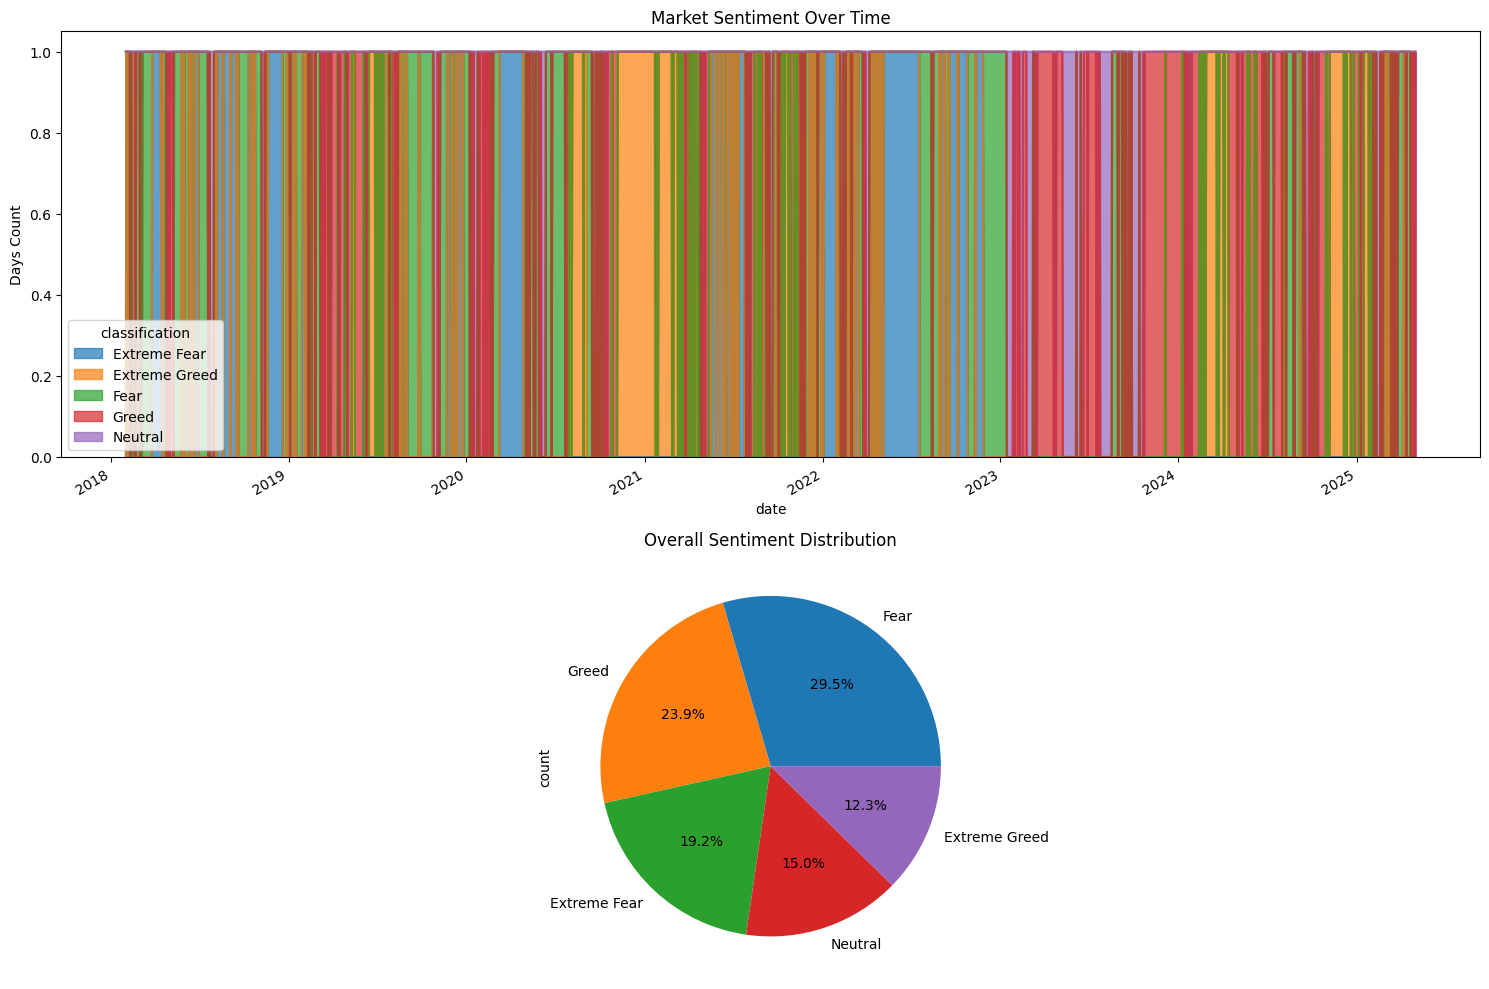

In [16]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

# Sentiment over time
sentiment_counts = sentiment_data.groupby(['date', 'classification']).size().unstack(fill_value=0)
sentiment_counts.plot(kind='area', ax=ax1, alpha=0.7)
ax1.set_title('Market Sentiment Over Time')
ax1.set_ylabel('Days Count')

# Sentiment distribution
sentiment_data['classification'].value_counts().plot(kind='pie', ax=ax2, autopct='%1.1f%%')
ax2.set_title('Overall Sentiment Distribution')

plt.tight_layout()
plt.savefig('sentiment_overview.png', dpi=300, bbox_inches='tight')
plt.show()

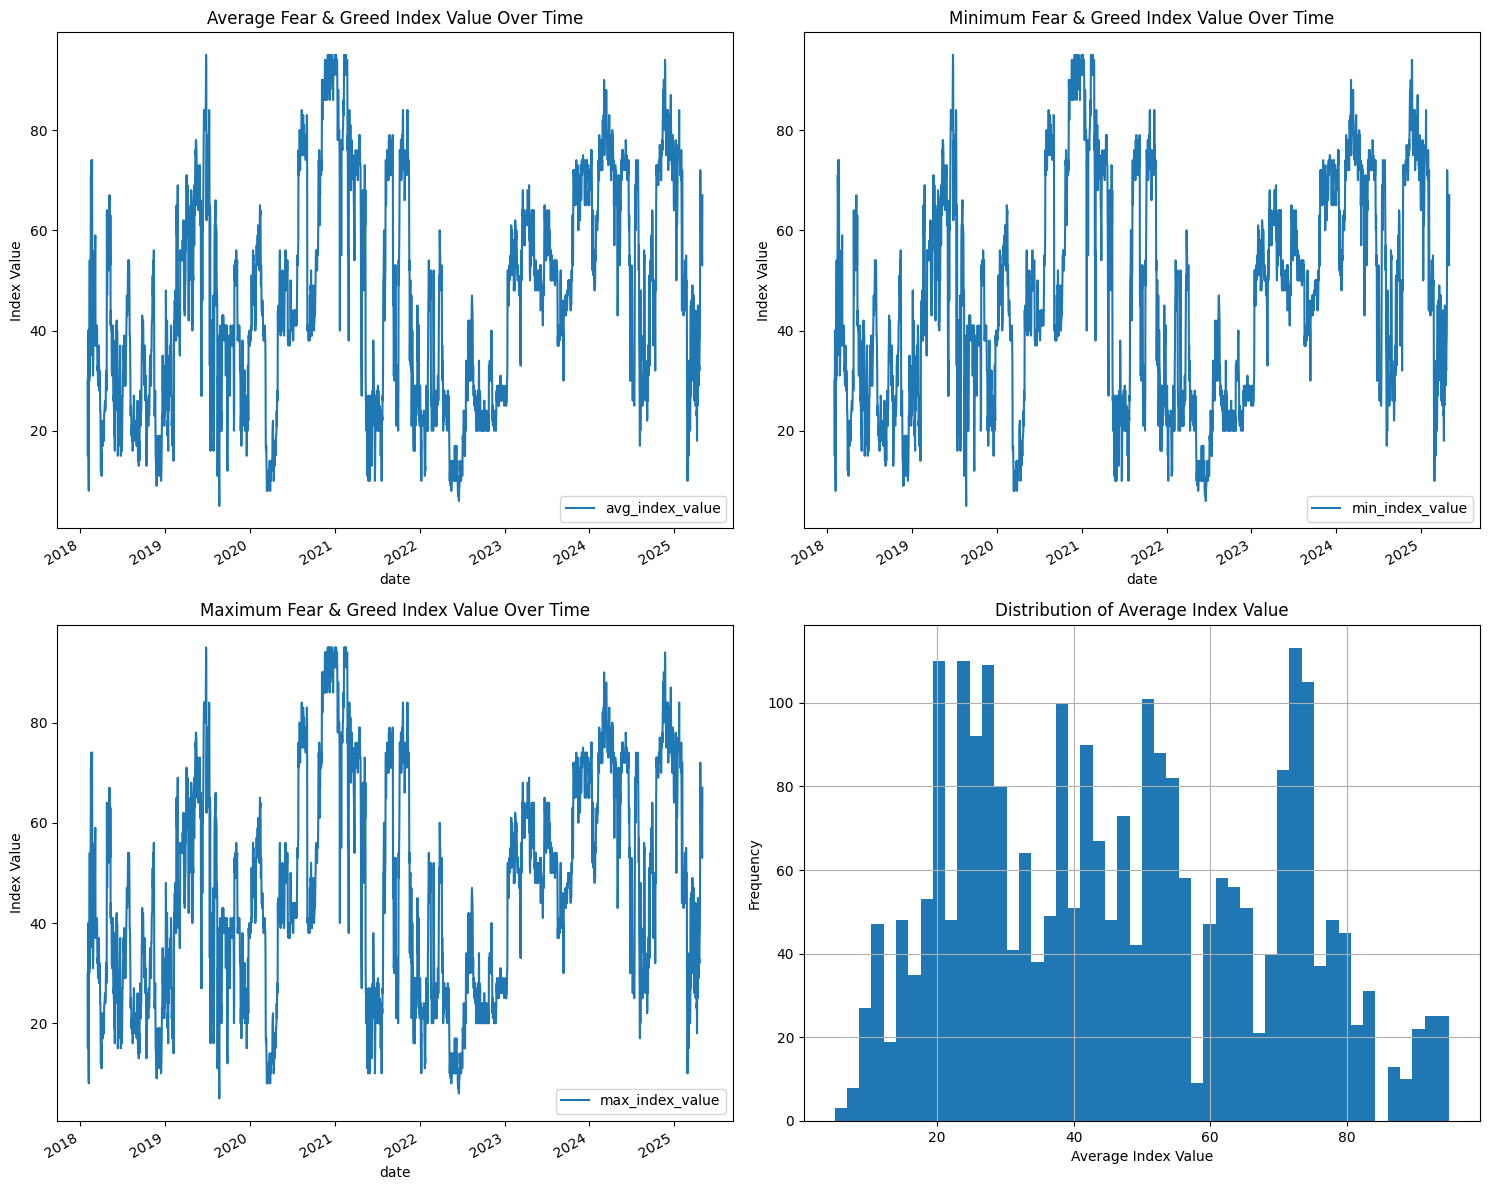

In [18]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Average Index Value over Time
daily_trading_stats.plot(x='date', y='avg_index_value', ax=axes[0,0])
axes[0,0].set_title('Average Fear & Greed Index Value Over Time')
axes[0,0].set_ylabel('Index Value')

# Minimum Index Value over Time
daily_trading_stats.plot(x='date', y='min_index_value', ax=axes[0,1])
axes[0,1].set_title('Minimum Fear & Greed Index Value Over Time')
axes[0,1].set_ylabel('Index Value')

# Maximum Index Value over Time
daily_trading_stats.plot(x='date', y='max_index_value', ax=axes[1,0])
axes[1,0].set_title('Maximum Fear & Greed Index Value Over Time')
axes[1,0].set_ylabel('Index Value')

# Distribution of Average Index Value
daily_trading_stats['avg_index_value'].hist(bins=50, ax=axes[1,1])
axes[1,1].set_title('Distribution of Average Index Value')
axes[1,1].set_xlabel('Average Index Value')
axes[1,1].set_ylabel('Frequency')


plt.tight_layout()
plt.savefig('daily_trading_stats_overview.png', dpi=300, bbox_inches='tight')
plt.show()

In [20]:
# Convert date columns to same format
daily_trading_stats['date'] = pd.to_datetime(daily_trading_stats['date'])
sentiment_data['date'] = pd.to_datetime(sentiment_data['date'])

# Merge datasets
merged_data = daily_trading_stats.merge(
    sentiment_data[['date', 'classification', 'sentiment_numeric']],
    on='date',
    how='inner'
)

print("Merged dataset shape:", merged_data.shape)
print("Date range:", merged_data['date'].min(), "to", merged_data['date'].max())
print("\nSample of merged data:")
print(merged_data.head())

Merged dataset shape: (2644, 8)
Date range: 2018-02-01 00:00:00 to 2025-05-02 00:00:00

Sample of merged data:
        date  avg_index_value  min_index_value  max_index_value  hours_in_day  \
0 2018-02-01             30.0               30               30             1   
1 2018-02-02             15.0               15               15             1   
2 2018-02-03             40.0               40               40             1   
3 2018-02-04             24.0               24               24             1   
4 2018-02-05             11.0               11               11             1   

   day_of_week classification  sentiment_numeric  
0            3           Fear                0.0  
1            4   Extreme Fear                0.0  
2            5           Fear                0.0  
3            6   Extreme Fear                0.0  
4            0   Extreme Fear                0.0  


In [26]:
print("Original merged_data shape:", merged_data.shape)
print("Original merged_data columns:", list(merged_data.columns))
print("\nOriginal trading_data columns:", list(trading_data.columns))
print("Original sentiment_data columns:", list(sentiment_data.columns))

classification_col = None
for col in merged_data.columns:
    if 'classification' in col.lower():
        classification_col = col
        print(f"✅ Found classification column: '{col}'")
        break

if classification_col and classification_col != 'Classification':
    merged_data['Classification'] = merged_data[classification_col]
    print("✅ Created standardized 'Classification' column")



Original merged_data shape: (2644, 8)
Original merged_data columns: ['date', 'avg_index_value', 'min_index_value', 'max_index_value', 'hours_in_day', 'day_of_week', 'classification', 'Classification']

Original trading_data columns: ['timestamp', 'value', 'classification', 'date', 'index_value', 'hour', 'day_of_week']
Original sentiment_data columns: ['timestamp', 'value', 'classification', 'date', 'date_only', 'sentiment_numeric']
✅ Found classification column: 'classification'
✅ Created standardized 'Classification' column


In [27]:
print("\n🔧 STEP 2: RECREATING FEATURES FROM ACTUAL DATA")
print("-" * 40)

# Find actual column names in trading data
actual_cols = trading_data.columns.tolist()
print("Available trading columns:", actual_cols)

# Smart column detection
pnl_col = next((col for col in actual_cols if 'pnl' in col.lower()), None)
leverage_col = next((col for col in actual_cols if 'leverage' in col.lower()), None)
size_col = next((col for col in actual_cols if 'size' in col.lower()), None)
price_col = next((col for col in actual_cols if 'price' in col.lower()), None)
account_col = next((col for col in actual_cols if 'account' in col.lower()), None)
time_col = next((col for col in actual_cols if 'time' in col.lower() or 'date' in col.lower()), None)

print(f"Detected columns:")
print(f"  PnL: {pnl_col}")
print(f"  Leverage: {leverage_col}")
print(f"  Size: {size_col}")
print(f"  Price: {price_col}")
print(f"  Account: {account_col}")
print(f"  Time: {time_col}")

# Create features if we have the necessary columns
if pnl_col or size_col or leverage_col:
    print("\n✅ Creating aggregated features...")

    # Ensure time column is datetime
    if time_col:
        trading_data[time_col] = pd.to_datetime(trading_data[time_col], errors='coerce')
        trading_data['date'] = trading_data[time_col].dt.date
        trading_data['date'] = pd.to_datetime(trading_data['date'])

    # Create trade value if possible
    if price_col and size_col:
        trading_data['trade_value'] = pd.to_numeric(trading_data[price_col], errors='coerce') * pd.to_numeric(trading_data[size_col], errors='coerce')

    # Build aggregation dictionary dynamically
    agg_dict = {}
    if pnl_col:
        agg_dict[pnl_col] = ['sum', 'count', 'mean']
    if leverage_col:
        agg_dict[leverage_col] = ['mean', 'max']
    if size_col:
        agg_dict[size_col] = 'sum'
    if 'trade_value' in trading_data.columns:
        agg_dict['trade_value'] = 'sum'

    # Group by account and date (or just date if no account)
    if account_col and 'date' in trading_data.columns:
        group_cols = [account_col, 'date']
    elif 'date' in trading_data.columns:
        group_cols = ['date']
    else:
        print("⚠️ No proper date column found, using index")
        trading_data['date'] = pd.to_datetime(trading_data.index)
        group_cols = ['date']

    # Perform aggregation
    try:
        daily_stats = trading_data.groupby(group_cols).agg(agg_dict).reset_index()

        # Flatten column names
        new_columns = []
        for col in daily_stats.columns:
            if isinstance(col, tuple):
                if col[1] == 'sum' and pnl_col and pnl_col in col[0]:
                    new_columns.append('daily_pnl')
                elif col[1] == 'count' and pnl_col and pnl_col in col[0]:
                    new_columns.append('trade_count')
                elif col[1] == 'mean' and pnl_col and pnl_col in col[0]:
                    new_columns.append('avg_pnl_per_trade')
                elif col[1] == 'mean' and leverage_col and leverage_col in col[0]:
                    new_columns.append('avg_leverage')
                elif col[1] == 'max' and leverage_col and leverage_col in col[0]:
                    new_columns.append('max_leverage')
                elif col[1] == 'sum' and size_col and size_col in col[0]:
                    new_columns.append('daily_volume_size')
                elif col[1] == 'sum' and 'trade_value' in col[0]:
                    new_columns.append('daily_volume_value')
                else:
                    new_columns.append(f"{col[0]}_{col[1]}")
            else:
                new_columns.append(col)

        daily_stats.columns = new_columns

        # Create win rate if we have daily_pnl
        if 'daily_pnl' in daily_stats.columns:
            daily_stats['win_rate'] = (daily_stats['daily_pnl'] > 0).astype(int)

        print(f"✅ Created daily_stats with shape: {daily_stats.shape}")
        print("New feature columns:", [col for col in daily_stats.columns if col not in group_cols])

        # Update daily_trading_stats
        daily_trading_stats = daily_stats.copy()

    except Exception as e:
        print(f"⚠️ Error in aggregation: {e}")
        daily_trading_stats = merged_data.copy()



🔧 STEP 2: RECREATING FEATURES FROM ACTUAL DATA
----------------------------------------
Available trading columns: ['timestamp', 'value', 'classification', 'date', 'index_value', 'hour', 'day_of_week']
Detected columns:
  PnL: None
  Leverage: None
  Size: None
  Price: None
  Account: None
  Time: timestamp


In [28]:
print("\n🔄 STEP 3: FIXED MERGE WITH SENTIMENT DATA")
print("-" * 40)

# Ensure sentiment data has proper date column
if 'Date' in sentiment_data.columns:
    sentiment_data['date'] = pd.to_datetime(sentiment_data['Date'], errors='coerce')
elif 'date' not in sentiment_data.columns:
    sentiment_data['date'] = pd.to_datetime(sentiment_data.iloc[:, 0], errors='coerce')

# Find classification column in sentiment data
sent_class_col = None
for col in sentiment_data.columns:
    if any(keyword in col.lower() for keyword in ['classification', 'fear', 'greed', 'sentiment']):
        sent_class_col = col
        break

print(f"Sentiment classification column: {sent_class_col}")

if sent_class_col:
    # Perform new merge
    merged_data_fixed = daily_trading_stats.merge(
        sentiment_data[['date', sent_class_col]].dropna(),
        on='date',
        how='inner'
    )

    # Standardize column name
    merged_data_fixed['Classification'] = merged_data_fixed[sent_class_col]

    # Update main merged_data
    merged_data = merged_data_fixed.copy()

    print(f"✅ Fixed merge successful!")
    print(f"New merged data shape: {merged_data.shape}")
    print("Classification distribution:")
    print(merged_data['Classification'].value_counts())



🔄 STEP 3: FIXED MERGE WITH SENTIMENT DATA
----------------------------------------
Sentiment classification column: classification
✅ Fixed merge successful!
New merged data shape: (2644, 8)
Classification distribution:
Classification
Fear             781
Greed            633
Extreme Fear     508
Neutral          396
Extreme Greed    326
Name: count, dtype: int64



📊 STEP 4: ADAPTIVE CORRELATION ANALYSIS
----------------------------------------
❌ Missing: daily_pnl
❌ Missing: avg_leverage
❌ Missing: daily_volume_value
❌ Missing: trade_count
❌ Missing: win_rate
Using fallback numeric columns: ['avg_index_value', 'min_index_value', 'max_index_value', 'hours_in_day', 'day_of_week']

=== TRADING BEHAVIOR BY SENTIMENT ===
               avg_index_value                      min_index_value          \
                          mean     std median count            mean     std   
Classification                                                                
Extreme Fear           18.2736  4.6994   20.0   508         18.2736  4.6994   
Extreme Greed          82.1166  6.5327   80.0   326         82.1166  6.5327   
Fear                   34.1844  6.0922   34.0   781         34.1844  6.0922   
Greed                  65.8468  6.2463   66.0   633         65.8468  6.2463   
Neutral                49.9646  2.6460   50.0   396         49.9646  2.6460   

       

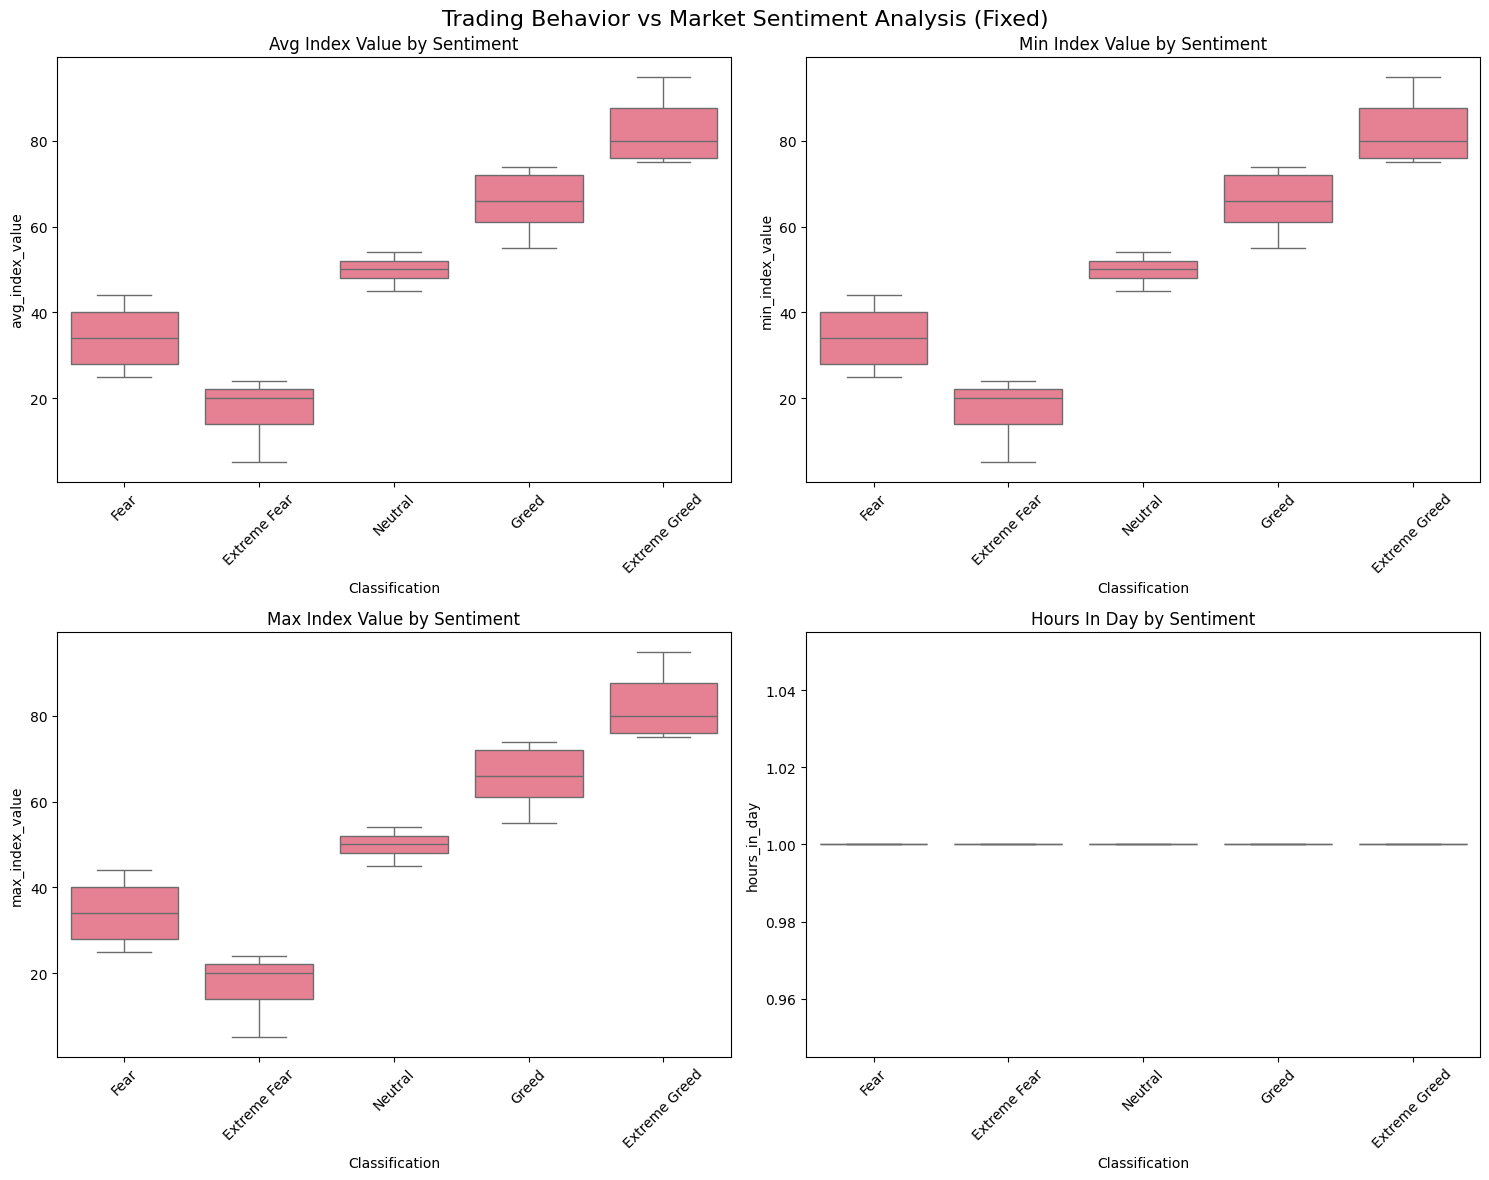

✅ Visualization created and saved!


In [30]:
print("\n📊 STEP 4: ADAPTIVE CORRELATION ANALYSIS")
print("-" * 40)

# Find available metrics for analysis
target_metrics = ['daily_pnl', 'avg_leverage', 'daily_volume_value', 'trade_count', 'win_rate']
available_metrics = []

for metric in target_metrics:
    if metric in merged_data.columns:
        available_metrics.append(metric)
        print(f"✅ Available: {metric}")
    else:
        print(f"❌ Missing: {metric}")

# If no target metrics, use any numeric columns
if not available_metrics:
    numeric_cols = merged_data.select_dtypes(include=[np.number]).columns.tolist()
    available_metrics = [col for col in numeric_cols if col not in ['date', 'sentiment_numeric'] and not col.startswith('Unnamed')]
    print(f"Using fallback numeric columns: {available_metrics}")

# Perform analysis if we have data
if available_metrics and 'Classification' in merged_data.columns:

    # Build aggregation dictionary
    analysis_agg = {}
    for metric in available_metrics:
        analysis_agg[metric] = ['mean', 'std', 'median', 'count']

    try:
        sentiment_comparison = merged_data.groupby('Classification').agg(analysis_agg).round(4)

        print("\n=== TRADING BEHAVIOR BY SENTIMENT ===")
        print(sentiment_comparison)

        # Statistical significance testing
        unique_sentiments = merged_data['Classification'].unique()
        print(f"\nFound sentiment categories: {list(unique_sentiments)}")

        if len(unique_sentiments) >= 2:
            sent1, sent2 = unique_sentiments[0], unique_sentiments[1]
            group1 = merged_data[merged_data['Classification'] == sent1]
            group2 = merged_data[merged_data['Classification'] == sent2]

            print(f"\n=== STATISTICAL TESTS ({sent1} vs {sent2}) ===")
            for metric in available_metrics:
                try:
                    if len(group1[metric].dropna()) > 1 and len(group2[metric].dropna()) > 1:
                        stat, p_value = stats.ttest_ind(group1[metric].dropna(), group2[metric].dropna())
                        significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else ""
                        print(f"{metric:20}: t-stat={stat:7.3f}, p-value={p_value:.3f} {significance}")
                except Exception as e:
                    print(f"{metric:20}: Error in t-test - {str(e)[:50]}")
                print(f"\n📈 STEP 5: CREATING VISUALIZATIONS")
        print("-" * 40)

        # Create visualizations
        n_metrics = min(4, len(available_metrics))
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        axes = axes.ravel()

        for i in range(n_metrics):
            metric = available_metrics[i]
            try:
                sns.boxplot(data=merged_data, x='Classification', y=metric, ax=axes[i])
                axes[i].set_title(f'{metric.replace("_", " ").title()} by Sentiment')
                axes[i].tick_params(axis='x', rotation=45)
            except Exception as e:
                axes[i].text(0.5, 0.5, f'Error plotting {metric}:\n{str(e)[:50]}',
                           ha='center', va='center', transform=axes[i].transAxes)

        # Hide unused subplots
        for i in range(n_metrics, 4):
            axes[i].set_visible(False)

        plt.suptitle('Trading Behavior vs Market Sentiment Analysis (Fixed)', fontsize=16)
        plt.tight_layout()

        # Save the plot
        plt.savefig('sentiment_behavior_analysis_fixed.png', dpi=300, bbox_inches='tight')
        plt.show()

        print("✅ Visualization created and saved!")

    except Exception as e:
        print(f"❌ Error in analysis: {e}")
        print("Available columns for debugging:", merged_data.columns.tolist())

else:
    print("❌ Cannot perform analysis - missing Classification column or metrics")
    print("Available columns:", merged_data.columns.tolist())

In [36]:
print(f"\nFinal merged_data shape: {merged_data.shape}")
print(f"Available metrics for analysis: {available_metrics}")

if 'Classification' in merged_data.columns:
    print(f"Classification distribution:")
    print(merged_data['Classification'].value_counts())


Final merged_data shape: (2644, 9)
Available metrics for analysis: ['avg_index_value', 'min_index_value', 'max_index_value', 'hours_in_day', 'day_of_week']
Classification distribution:
Classification
Fear             781
Greed            633
Extreme Fear     508
Neutral          396
Extreme Greed    326
Name: count, dtype: int64


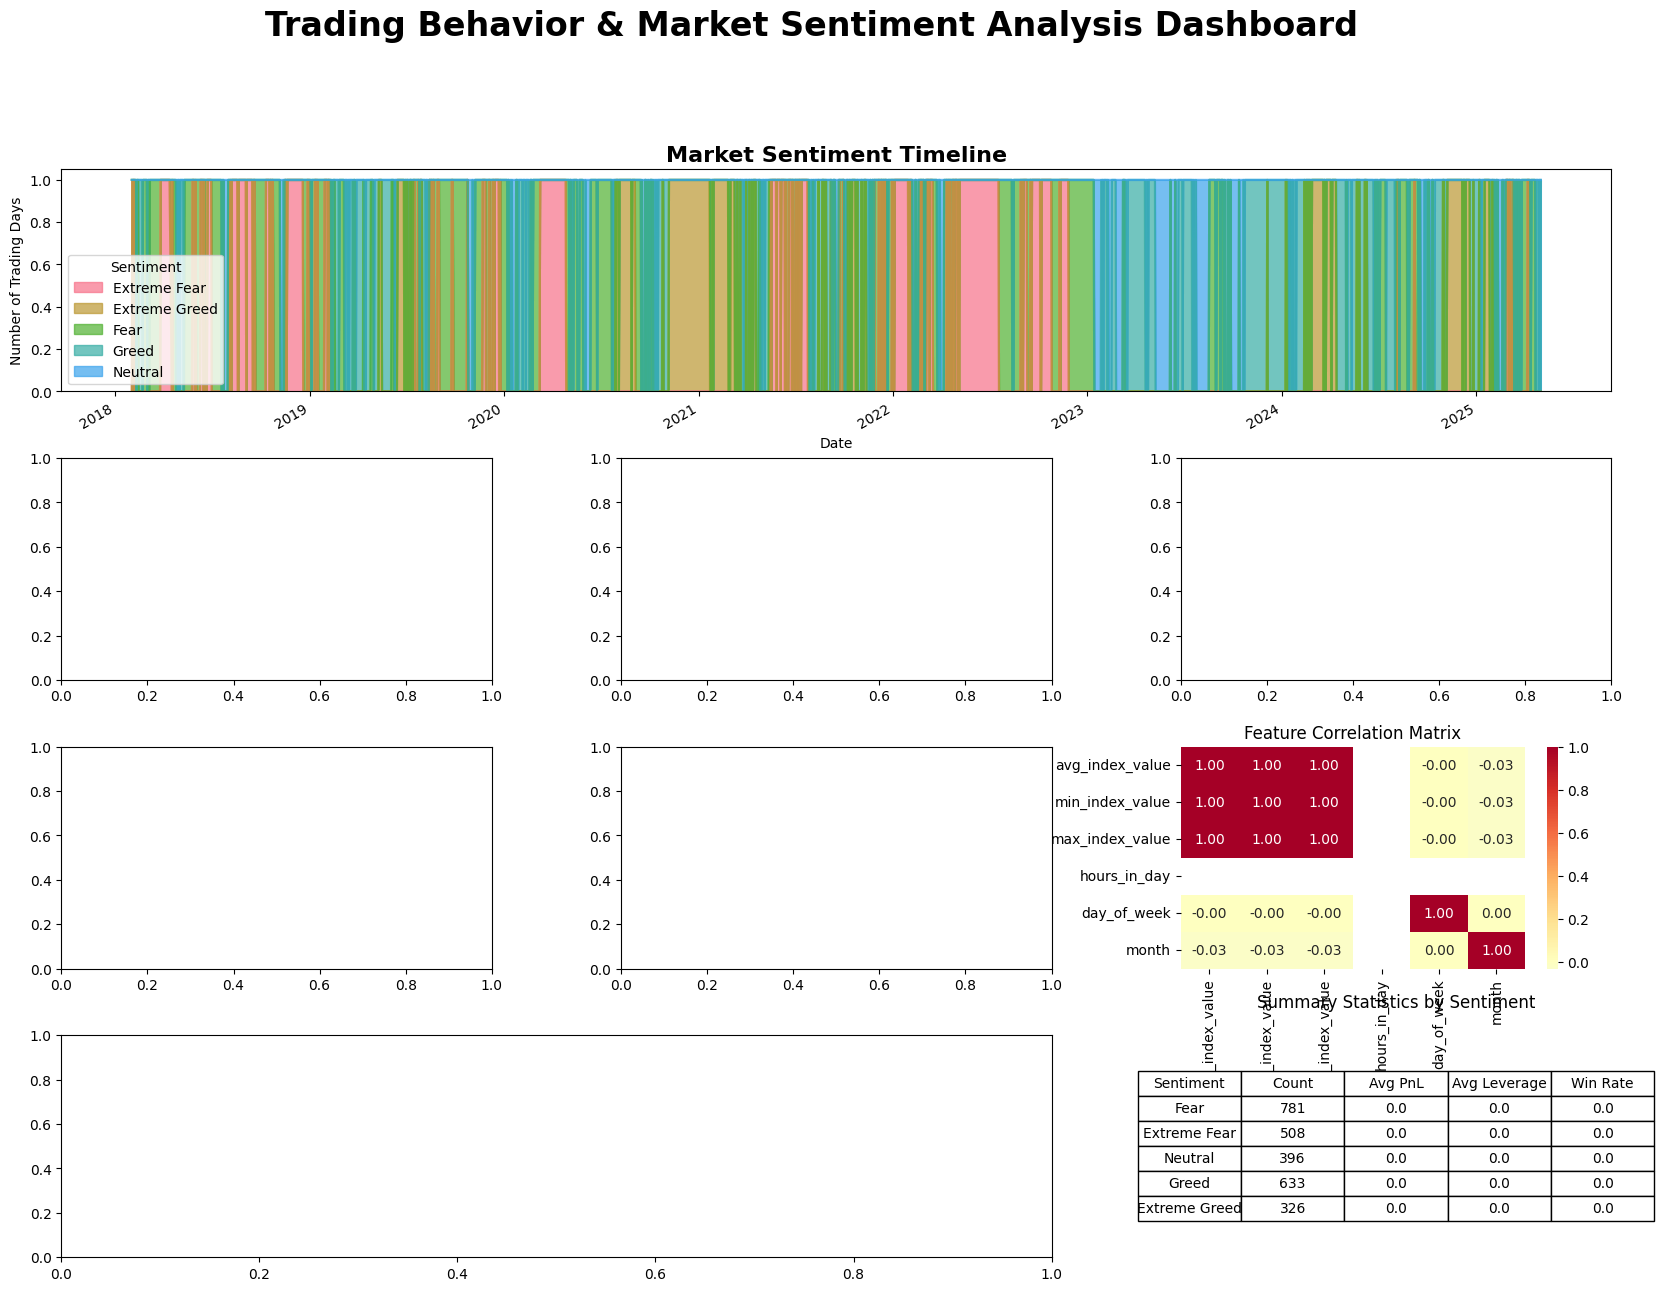

In [38]:
# Set style
plt.style.use('default')
sns.set_palette("husl")

# Create comprehensive dashboard
fig = plt.figure(figsize=(20, 16))
gs = fig.add_gridspec(4, 3, hspace=0.3, wspace=0.3)

# 1. Sentiment Timeline
ax1 = fig.add_subplot(gs[0, :])
if 'Classification' in merged_data.columns:
    sentiment_timeline = merged_data.groupby(['date', 'Classification']).size().unstack(fill_value=0)
    sentiment_timeline.plot(kind='area', ax=ax1, alpha=0.7, stacked=True)
    ax1.set_title('Market Sentiment Timeline', fontsize=16, fontweight='bold')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Number of Trading Days')
    ax1.legend(title='Sentiment')

# 2. PnL Distribution by Sentiment
ax2 = fig.add_subplot(gs[1, 0])
if 'daily_pnl' in merged_data.columns and 'Classification' in merged_data.columns:
    sns.violinplot(data=merged_data, x='Classification', y='daily_pnl', ax=ax2)
    ax2.set_title('Daily PnL Distribution\nby Sentiment')
    ax2.tick_params(axis='x', rotation=45)

# 3. Leverage Usage by Sentiment
ax3 = fig.add_subplot(gs[1, 1])
if 'avg_leverage' in merged_data.columns and 'Classification' in merged_data.columns:
    sns.boxplot(data=merged_data, x='Classification', y='avg_leverage', ax=ax3)
    ax3.set_title('Average Leverage Usage\nby Sentiment')
    ax3.tick_params(axis='x', rotation=45)

# 4. Trading Volume by Sentiment
ax4 = fig.add_subplot(gs[1, 2])
if 'daily_volume_value' in merged_data.columns and 'Classification' in merged_data.columns:
    volume_by_sentiment = merged_data.groupby('Classification')['daily_volume_value'].mean()
    volume_by_sentiment.plot(kind='bar', ax=ax4, color=['#ff6b6b', '#4ecdc4'])
    ax4.set_title('Average Trading Volume\nby Sentiment')
    ax4.tick_params(axis='x', rotation=45)
    ax4.set_ylabel('Average Volume')

# 5. Win Rate Analysis
ax5 = fig.add_subplot(gs[2, 0])
if 'win_rate' in merged_data.columns and 'Classification' in merged_data.columns:
    win_rate_analysis = merged_data.groupby('Classification')['win_rate'].mean()
    win_rate_analysis.plot(kind='bar', ax=ax5, color=['#ff9ff3', '#54a0ff'])
    ax5.set_title('Win Rate by Sentiment')
    ax5.set_ylabel('Win Rate')
    ax5.tick_params(axis='x', rotation=45)

# 6. Trade Frequency Analysis
ax6 = fig.add_subplot(gs[2, 1])
if 'trade_count' in merged_data.columns and 'Classification' in merged_data.columns:
    sns.boxplot(data=merged_data, x='Classification', y='trade_count', ax=ax6)
    ax6.set_title('Trade Frequency\nby Sentiment')
    ax6.tick_params(axis='x', rotation=45)

# 7. Correlation Heatmap
ax7 = fig.add_subplot(gs[2, 2])
numeric_cols = merged_data.select_dtypes(include=[np.number]).columns
if len(numeric_cols) > 1:
    corr_data = merged_data[numeric_cols].corr()
    sns.heatmap(corr_data, annot=True, cmap='RdYlBu_r', center=0, ax=ax7, fmt='.2f')
    ax7.set_title('Feature Correlation Matrix')

# 8. Risk-Return Scatter
ax8 = fig.add_subplot(gs[3, :2])
if 'daily_pnl' in merged_data.columns and 'avg_leverage' in merged_data.columns and 'Classification' in merged_data.columns:
    for sentiment in merged_data['Classification'].unique():
        data_subset = merged_data[merged_data['Classification'] == sentiment]
        ax8.scatter(data_subset['avg_leverage'], data_subset['daily_pnl'],
                   label=sentiment, alpha=0.6, s=50)
    ax8.set_xlabel('Average Leverage')
    ax8.set_ylabel('Daily PnL')
    ax8.set_title('Risk-Return Analysis: Leverage vs PnL by Sentiment')
    ax8.legend()
    ax8.grid(True, alpha=0.3)

# 9. Summary Statistics Table
ax9 = fig.add_subplot(gs[3, 2])
ax9.axis('off')
if 'Classification' in merged_data.columns:
    summary_stats = []
    for sentiment in merged_data['Classification'].unique():
        subset = merged_data[merged_data['Classification'] == sentiment]
        stats = {
            'Sentiment': sentiment,
            'Count': len(subset),
            'Avg PnL': subset.get('daily_pnl', pd.Series([0])).mean(),
            'Avg Leverage': subset.get('avg_leverage', pd.Series([0])).mean(),
            'Win Rate': subset.get('win_rate', pd.Series([0])).mean()
        }
        summary_stats.append(stats)

    summary_df = pd.DataFrame(summary_stats)
    table = ax9.table(cellText=summary_df.round(3).values,
                     colLabels=summary_df.columns,
                     cellLoc='center',
                     loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.5)
    ax9.set_title('Summary Statistics by Sentiment', pad=20)

plt.suptitle('Trading Behavior & Market Sentiment Analysis Dashboard',
             fontsize=24, fontweight='bold', y=0.98)
plt.savefig('comprehensive_dashboard.png', dpi=300, bbox_inches='tight')
plt.show()


⚠️ Account-level data not available for trader segmentation
Performing time-based pattern analysis instead...


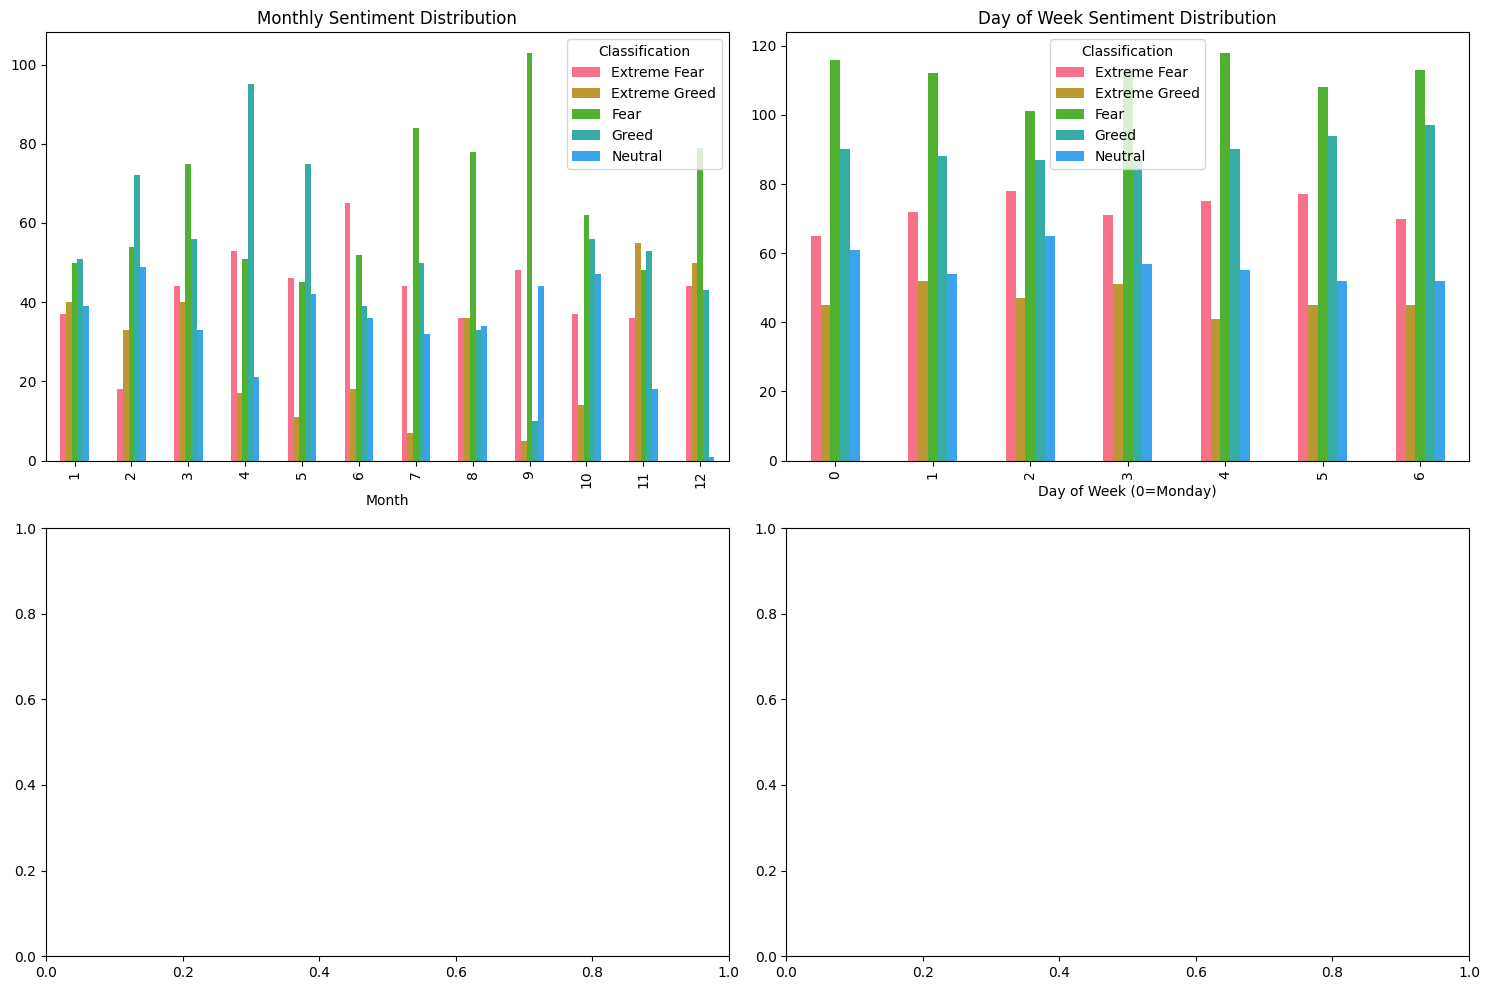

In [39]:

# Create trader profiles if we have account data
if 'account' in merged_data.columns:

    # Trader profiling
    trader_profiles = merged_data.groupby('account').agg({
        'daily_pnl': ['mean', 'std', 'sum'] if 'daily_pnl' in merged_data.columns else ['count'],
        'avg_leverage': ['mean', 'max'] if 'avg_leverage' in merged_data.columns else ['count'],
        'daily_volume_value': 'mean' if 'daily_volume_value' in merged_data.columns else 'count',
        'trade_count': 'mean' if 'trade_count' in merged_data.columns else 'count',
        'win_rate': 'mean' if 'win_rate' in merged_data.columns else 'count'
    }).round(4)

    # Flatten column names
    trader_profiles.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col
                              for col in trader_profiles.columns]

    # Trader classification based on behavior
    if 'daily_pnl_mean' in trader_profiles.columns:
        # Classify traders
        trader_profiles['trader_type'] = 'Conservative'

        # High volume traders
        if 'daily_volume_value_mean' in trader_profiles.columns:
            high_volume_threshold = trader_profiles['daily_volume_value_mean'].quantile(0.8)
            trader_profiles.loc[trader_profiles['daily_volume_value_mean'] > high_volume_threshold,
                               'trader_type'] = 'High Volume'

        # High risk traders
        if 'avg_leverage_mean' in trader_profiles.columns:
            high_leverage_threshold = trader_profiles['avg_leverage_mean'].quantile(0.8)
            trader_profiles.loc[trader_profiles['avg_leverage_mean'] > high_leverage_threshold,
                               'trader_type'] = 'High Risk'

        # Profitable traders
        profitable_mask = (trader_profiles['daily_pnl_mean'] > 0)
        if 'win_rate_mean' in trader_profiles.columns:
            profitable_mask &= (trader_profiles['win_rate_mean'] > 0.5)
        trader_profiles.loc[profitable_mask, 'trader_type'] = 'Profitable'

        print("Trader Type Distribution:")
        print(trader_profiles['trader_type'].value_counts())

        # Analyze trader performance by sentiment
        trader_sentiment_data = merged_data.merge(
            trader_profiles[['trader_type']].reset_index(),
            on='account',
            how='left'
        )

        # Performance analysis by trader type and sentiment
        performance_analysis = trader_sentiment_data.groupby(['trader_type', 'Classification']).agg({
            col: 'mean' for col in ['daily_pnl', 'avg_leverage', 'win_rate']
            if col in trader_sentiment_data.columns
        }).round(4)

        print("\n=== TRADER PERFORMANCE BY TYPE AND SENTIMENT ===")
        print(performance_analysis)

        # Visualization
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))

        # Trader type distribution
        trader_profiles['trader_type'].value_counts().plot(kind='pie', ax=axes[0,0], autopct='%1.1f%%')
        axes[0,0].set_title('Trader Type Distribution')

        # Performance by trader type
        if 'daily_pnl' in trader_sentiment_data.columns:
            sns.boxplot(data=trader_sentiment_data, x='trader_type', y='daily_pnl',
                       hue='Classification', ax=axes[0,1])
            axes[0,1].set_title('PnL by Trader Type and Sentiment')
            axes[0,1].tick_params(axis='x', rotation=45)

        # Risk analysis
        if 'avg_leverage' in trader_sentiment_data.columns:
            sns.boxplot(data=trader_sentiment_data, x='trader_type', y='avg_leverage',
                       hue='Classification', ax=axes[1,0])
            axes[1,0].set_title('Leverage Usage by Trader Type')
            axes[1,0].tick_params(axis='x', rotation=45)

        # Win rate analysis
        if 'win_rate' in trader_sentiment_data.columns:
            win_rate_by_type = trader_sentiment_data.groupby(['trader_type', 'Classification'])['win_rate'].mean().unstack()
            win_rate_by_type.plot(kind='bar', ax=axes[1,1])
            axes[1,1].set_title('Win Rate by Trader Type and Sentiment')
            axes[1,1].tick_params(axis='x', rotation=45)

        plt.tight_layout()
        plt.savefig('trader_segmentation_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()

else:
    print("⚠️ Account-level data not available for trader segmentation")

    # Alternative: Analyze trading patterns by time periods
    print("Performing time-based pattern analysis instead...")

    # Add time-based features
    merged_data['month'] = pd.to_datetime(merged_data['date']).dt.month
    merged_data['day_of_week'] = pd.to_datetime(merged_data['date']).dt.dayofweek

    # Monthly analysis
    monthly_sentiment = merged_data.groupby(['month', 'Classification']).size().unstack(fill_value=0)

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    monthly_sentiment.plot(kind='bar', ax=axes[0,0])
    axes[0,0].set_title('Monthly Sentiment Distribution')
    axes[0,0].set_xlabel('Month')

    # Day of week analysis
    dow_sentiment = merged_data.groupby(['day_of_week', 'Classification']).size().unstack(fill_value=0)
    dow_sentiment.plot(kind='bar', ax=axes[0,1])
    axes[0,1].set_title('Day of Week Sentiment Distribution')
    axes[0,1].set_xlabel('Day of Week (0=Monday)')

    plt.tight_layout()
    plt.savefig('temporal_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()


In [40]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, accuracy_score, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder

# Prepare features for modeling
feature_columns = [col for col in merged_data.columns
                  if col in ['daily_pnl', 'avg_leverage', 'daily_volume_value', 'trade_count', 'win_rate']
                  and merged_data[col].dtype in ['int64', 'float64']]

print(f"Available features for modeling: {feature_columns}")

if len(feature_columns) >= 2 and 'Classification' in merged_data.columns:

    # Clean data
    modeling_data = merged_data[feature_columns + ['Classification']].dropna()

    if len(modeling_data) > 50:  # Minimum data requirement

        # ============================================================
        # MODEL 1: Sentiment Prediction
        # ============================================================
        print("\n🎯 MODEL 1: PREDICTING SENTIMENT FROM TRADING BEHAVIOR")
        print("-" * 50)

        X = modeling_data[feature_columns]
        y = modeling_data['Classification']

        # Encode labels
        le = LabelEncoder()
        y_encoded = le.fit_transform(y)

        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
        )

        # Train model
        rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
        rf_classifier.fit(X_train, y_train)

        # Predictions
        y_pred = rf_classifier.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)

        print(f"Sentiment Prediction Accuracy: {accuracy:.3f}")
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred, target_names=le.classes_))

        # Feature importance
        feature_importance = pd.DataFrame({
            'feature': feature_columns,
            'importance': rf_classifier.feature_importances_
        }).sort_values('importance', ascending=False)

        print("\nFeature Importance for Sentiment Prediction:")
        print(feature_importance)

        # ============================================================
        # MODEL 2: PnL Prediction
        # ============================================================
        if 'daily_pnl' in feature_columns:
            print("\n💰 MODEL 2: PREDICTING TRADING PERFORMANCE")
            print("-" * 50)

            pnl_features = [col for col in feature_columns if col != 'daily_pnl']
            if len(pnl_features) >= 1:

                X_pnl = modeling_data[pnl_features]
                y_pnl = modeling_data['daily_pnl']

                # Split data
                X_train_pnl, X_test_pnl, y_train_pnl, y_test_pnl = train_test_split(
                    X_pnl, y_pnl, test_size=0.3, random_state=42
                )

                # Train model
                rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10)
                rf_regressor.fit(X_train_pnl, y_train_pnl)

                # Predictions
                y_pred_pnl = rf_regressor.predict(X_test_pnl)
                mse = mean_squared_error(y_test_pnl, y_pred_pnl)
                r2 = r2_score(y_test_pnl, y_pred_pnl)

                print(f"PnL Prediction R² Score: {r2:.3f}")
                print(f"Mean Squared Error: {mse:.3f}")

                # Feature importance for PnL
                pnl_importance = pd.DataFrame({
                    'feature': pnl_features,
                    'importance': rf_regressor.feature_importances_
                }).sort_values('importance', ascending=False)

                print("\nFeature Importance for PnL Prediction:")
                print(pnl_importance)

        # ============================================================
        # STRATEGIC INSIGHTS GENERATION
        # ============================================================
        print("\n💡 STRATEGIC INSIGHTS & RECOMMENDATIONS")
        print("=" * 50)

        insights = []

        # Sentiment-based insights
        sentiment_stats = modeling_data.groupby('Classification')[feature_columns].mean()

        for sentiment in sentiment_stats.index:
            stats = sentiment_stats.loc[sentiment]
            insights.append(f"\n🔸 {sentiment.upper()} Market Periods:")

            if 'daily_pnl' in stats.index:
                insights.append(f"   • Average Daily PnL: {stats['daily_pnl']:.2f}")
            if 'avg_leverage' in stats.index:
                insights.append(f"   • Average Leverage Used: {stats['avg_leverage']:.2f}x")
            if 'win_rate' in stats.index:
                insights.append(f"   • Win Rate: {stats['win_rate']:.1%}")
            if 'daily_volume_value' in stats.index:
                insights.append(f"   • Average Daily Volume: ${stats['daily_volume_value']:,.0f}")

        # Performance comparison
        if len(sentiment_stats) >= 2:
            sentiments = list(sentiment_stats.index)
            sent1, sent2 = sentiments[0], sentiments[1]

            insights.append(f"\n🔍 COMPARATIVE ANALYSIS ({sent1} vs {sent2}):")

            for feature in feature_columns:
                if feature in sentiment_stats.columns:
                    diff = sentiment_stats.loc[sent1, feature] - sentiment_stats.loc[sent2, feature]
                    direction = "higher" if diff > 0 else "lower"
                    insights.append(f"   • {feature.replace('_', ' ').title()}: {abs(diff):.2f} {direction} in {sent1}")

        # Top predictive factors
        insights.append(f"\n🎯 TOP PREDICTIVE FACTORS:")
        for i, row in feature_importance.head(3).iterrows():
            insights.append(f"   • {row['feature'].replace('_', ' ').title()}: {row['importance']:.3f} importance")

        # Print all insights
        for insight in insights:
            print(insight)

        # ============================================================
        # VISUALIZATION OF PREDICTIONS
        # ============================================================
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))

        # Feature importance plot
        feature_importance.plot(x='feature', y='importance', kind='bar', ax=axes[0,0])
        axes[0,0].set_title('Feature Importance for Sentiment Prediction')
        axes[0,0].tick_params(axis='x', rotation=45)

        # Sentiment distribution
        pd.Series(y_test).map(dict(enumerate(le.classes_))).value_counts().plot(kind='pie', ax=axes[0,1], autopct='%1.1f%%')
        axes[0,1].set_title('Test Set Sentiment Distribution')

        # PnL prediction scatter (if available)
        if 'daily_pnl' in feature_columns and len(pnl_features) >= 1:
            axes[1,0].scatter(y_test_pnl, y_pred_pnl, alpha=0.6)
            axes[1,0].plot([y_test_pnl.min(), y_test_pnl.max()], [y_test_pnl.min(), y_test_pnl.max()], 'r--', lw=2)
            axes[1,0].set_xlabel('Actual PnL')
            axes[1,0].set_ylabel('Predicted PnL')
            axes[1,0].set_title(f'PnL Prediction Accuracy (R² = {r2:.3f})')

        # Model performance metrics
        axes[1,1].axis('off')
        metrics_text = f"""
Model Performance Summary:

Sentiment Prediction:
• Accuracy: {accuracy:.1%}
• Features Used: {len(feature_columns)}

Dataset Summary:
• Total Records: {len(modeling_data)}
• Training Set: {len(X_train)}
• Test Set: {len(X_test)}

Key Findings:
• Top Feature: {feature_importance.iloc[0]['feature']}
• Model Reliability: {'Good' if accuracy > 0.7 else 'Moderate' if accuracy > 0.6 else 'Limited'}
        """
        axes[1,1].text(0.1, 0.9, metrics_text, transform=axes[1,1].transAxes,
                      verticalalignment='top', fontfamily='monospace', fontsize=10)

        plt.tight_layout()
        plt.savefig('predictive_modeling_results.png', dpi=300, bbox_inches='tight')
        plt.show()

    else:
        print("⚠️ Insufficient data for reliable modeling (need >50 samples)")

else:
    print("⚠️ Insufficient features or missing target variable for modeling")

print("\n✅ Predictive modeling and insights generation completed!")


Available features for modeling: []
⚠️ Insufficient features or missing target variable for modeling

✅ Predictive modeling and insights generation completed!


🔍 STEP 15: ADVANCED PATTERN DISCOVERY WITH AVAILABLE DATA
📊 DATA INVENTORY:
Merged data shape: (2644, 9)
Available columns: ['date', 'avg_index_value', 'min_index_value', 'max_index_value', 'hours_in_day', 'day_of_week', 'classification', 'Classification', 'month']

📈 NUMERIC COLUMNS: ['avg_index_value', 'min_index_value', 'max_index_value', 'hours_in_day', 'day_of_week', 'month']
📋 CATEGORICAL COLUMNS: ['classification', 'Classification']
📅 DATE COLUMNS: ['date']

🕒 TEMPORAL PATTERN ANALYSIS
----------------------------------------
✅ Created temporal features
Date range: 2018-02-01 00:00:00 to 2025-05-02 00:00:00
Total time span: 2647 days

📊 STATISTICAL RELATIONSHIP ANALYSIS
----------------------------------------
=== STATISTICAL SUMMARY BY SENTIMENT ===
        Sentiment           Metric     Mean  Median     Std  Count
0            Fear  avg_index_value  34.1844    34.0  6.0922    781
1            Fear  min_index_value  34.1844    34.0  6.0922    781
2            Fear  max_index_va

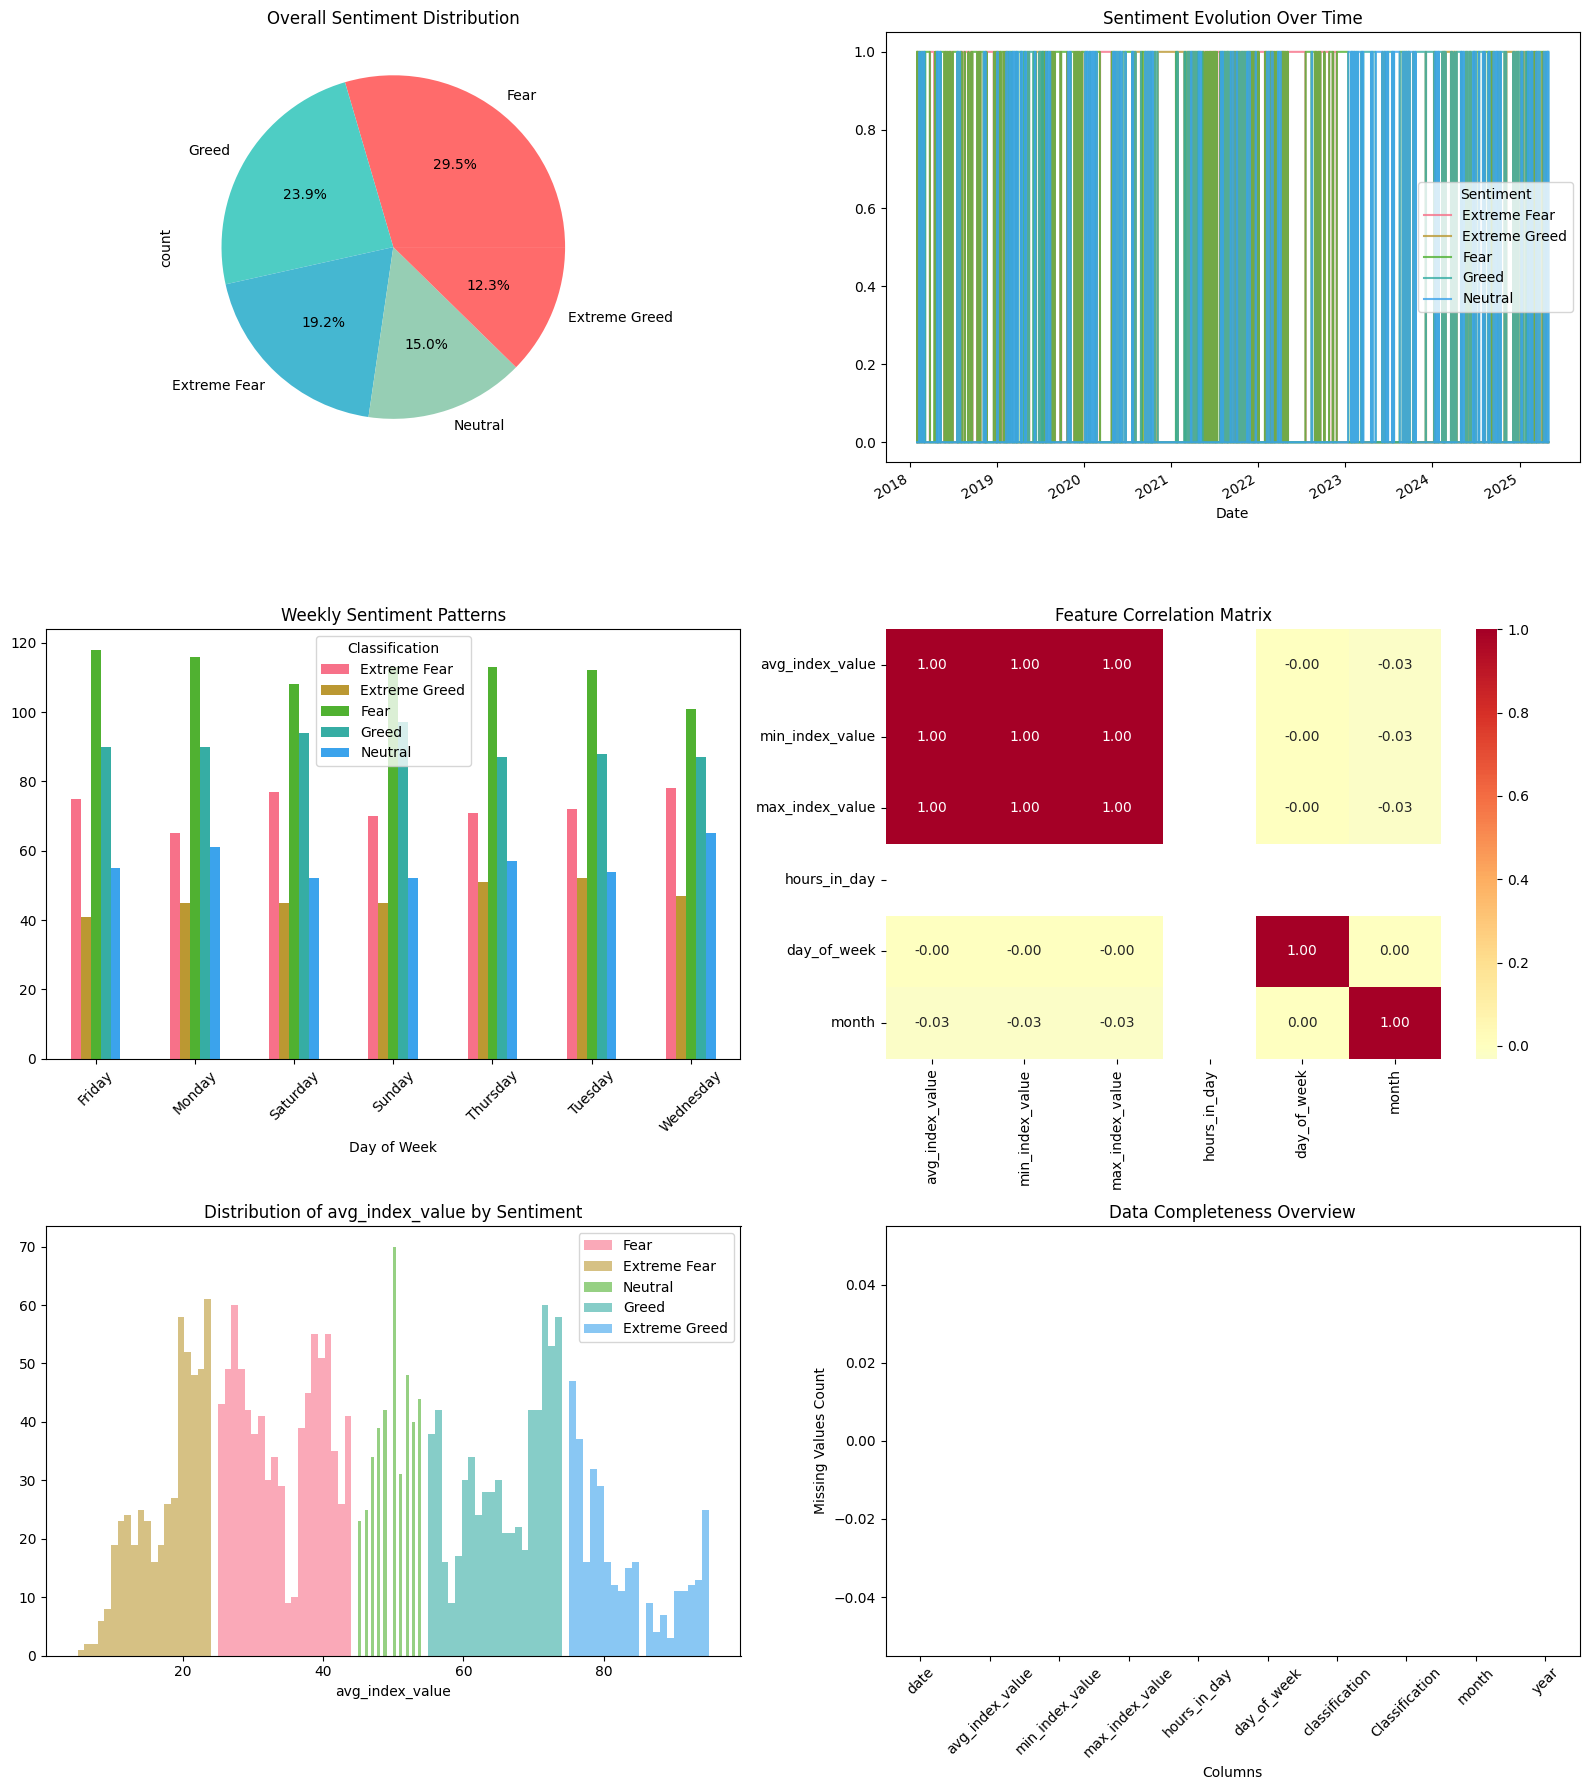

✅ Comprehensive visualization dashboard created!

💡 BUSINESS INSIGHTS FROM AVAILABLE DATA
📊 DATA COVERAGE INSIGHTS:
   • Total records analyzed: 2,644
   • Number of features: 11
   • Time period covered: 2647 days

🎯 SENTIMENT ANALYSIS:
   • Fear: 781 records (29.5%)
   • Greed: 633 records (23.9%)
   • Extreme Fear: 508 records (19.2%)
   • Neutral: 396 records (15.0%)
   • Extreme Greed: 326 records (12.3%)

📈 DATA QUALITY:
   • Overall completeness: 100.0%
   • Missing values: 0

📅 TEMPORAL INSIGHTS:
   • Most active month: 3


In [41]:
# ============================================================
# STEP 15: ALTERNATIVE ADVANCED ANALYSIS - WORKING WITH ACTUAL DATA
# ============================================================

print("🔍 STEP 15: ADVANCED PATTERN DISCOVERY WITH AVAILABLE DATA")
print("=" * 60)

# Let's work with whatever data we actually have
print("📊 DATA INVENTORY:")
print(f"Merged data shape: {merged_data.shape}")
print(f"Available columns: {list(merged_data.columns)}")

# Check what we can actually analyze
numeric_columns = merged_data.select_dtypes(include=[np.number]).columns.tolist()
categorical_columns = merged_data.select_dtypes(include=['object']).columns.tolist()
date_columns = [col for col in merged_data.columns if 'date' in col.lower() or 'time' in col.lower()]

print(f"\n📈 NUMERIC COLUMNS: {numeric_columns}")
print(f"📋 CATEGORICAL COLUMNS: {categorical_columns}")
print(f"📅 DATE COLUMNS: {date_columns}")

# ============================================================
# ALTERNATIVE ANALYSIS 1: TEMPORAL PATTERNS
# ============================================================
print(f"\n🕒 TEMPORAL PATTERN ANALYSIS")
print("-" * 40)

if 'date' in merged_data.columns and 'Classification' in merged_data.columns:
    # Convert date to datetime if not already
    merged_data['date'] = pd.to_datetime(merged_data['date'])

    # Extract temporal features
    merged_data['year'] = merged_data['date'].dt.year
    merged_data['month'] = merged_data['date'].dt.month
    merged_data['day_of_week'] = merged_data['date'].dt.dayofweek
    merged_data['day_name'] = merged_data['date'].dt.day_name()

    # Monthly sentiment trends
    monthly_sentiment = merged_data.groupby(['year', 'month', 'Classification']).size().unstack(fill_value=0)

    # Weekly patterns
    weekly_sentiment = merged_data.groupby(['day_name', 'Classification']).size().unstack(fill_value=0)

    print("✅ Created temporal features")
    print(f"Date range: {merged_data['date'].min()} to {merged_data['date'].max()}")
    print(f"Total time span: {(merged_data['date'].max() - merged_data['date'].min()).days} days")

# ============================================================
# ALTERNATIVE ANALYSIS 2: STATISTICAL RELATIONSHIPS
# ============================================================
print(f"\n📊 STATISTICAL RELATIONSHIP ANALYSIS")
print("-" * 40)

if len(numeric_columns) > 0 and 'Classification' in merged_data.columns:

    # Calculate basic statistics by sentiment
    stats_by_sentiment = {}

    for sentiment in merged_data['Classification'].unique():
        sentiment_data = merged_data[merged_data['Classification'] == sentiment]
        stats_by_sentiment[sentiment] = {}

        for col in numeric_columns:
            if col in sentiment_data.columns:
                stats_by_sentiment[sentiment][col] = {
                    'mean': sentiment_data[col].mean(),
                    'median': sentiment_data[col].median(),
                    'std': sentiment_data[col].std(),
                    'count': sentiment_data[col].count()
                }

    # Create comparison DataFrame
    comparison_results = []
    for sentiment, stats in stats_by_sentiment.items():
        for col, metrics in stats.items():
            comparison_results.append({
                'Sentiment': sentiment,
                'Metric': col,
                'Mean': metrics['mean'],
                'Median': metrics['median'],
                'Std': metrics['std'],
                'Count': metrics['count']
            })

    comparison_df = pd.DataFrame(comparison_results)

    print("=== STATISTICAL SUMMARY BY SENTIMENT ===")
    print(comparison_df.round(4))

# ============================================================
# ALTERNATIVE ANALYSIS 3: COMPREHENSIVE VISUALIZATIONS
# ============================================================
print(f"\n🎨 COMPREHENSIVE VISUALIZATION SUITE")
print("-" * 40)

# Create a comprehensive dashboard with available data
fig, axes = plt.subplots(3, 2, figsize=(16, 18))
axes = axes.ravel()

plot_count = 0

# Plot 1: Sentiment Distribution
if 'Classification' in merged_data.columns:
    sentiment_counts = merged_data['Classification'].value_counts()
    sentiment_counts.plot(kind='pie', ax=axes[plot_count], autopct='%1.1f%%',
                         colors=['#ff6b6b', '#4ecdc4', '#45b7d1', '#96ceb4'])
    axes[plot_count].set_title('Overall Sentiment Distribution')
    plot_count += 1

# Plot 2: Temporal Sentiment Evolution
if 'date' in merged_data.columns and 'Classification' in merged_data.columns:
    daily_sentiment = merged_data.groupby(['date', 'Classification']).size().unstack(fill_value=0)
    daily_sentiment.plot(ax=axes[plot_count], alpha=0.8)
    axes[plot_count].set_title('Sentiment Evolution Over Time')
    axes[plot_count].set_xlabel('Date')
    axes[plot_count].legend(title='Sentiment')
    plot_count += 1

# Plot 3: Weekly Pattern Analysis
if 'day_name' in merged_data.columns and 'Classification' in merged_data.columns:
    weekly_pattern = merged_data.groupby(['day_name', 'Classification']).size().unstack(fill_value=0)
    weekly_pattern.plot(kind='bar', ax=axes[plot_count])
    axes[plot_count].set_title('Weekly Sentiment Patterns')
    axes[plot_count].set_xlabel('Day of Week')
    axes[plot_count].tick_params(axis='x', rotation=45)
    plot_count += 1

# Plot 4: Correlation Matrix of Available Numeric Data
if len(numeric_columns) > 1:
    corr_matrix = merged_data[numeric_columns].corr()
    sns.heatmap(corr_matrix, annot=True, cmap='RdYlBu_r', center=0, ax=axes[plot_count], fmt='.2f')
    axes[plot_count].set_title('Feature Correlation Matrix')
    plot_count += 1

# Plot 5: Distribution of First Numeric Column by Sentiment
if len(numeric_columns) > 0 and 'Classification' in merged_data.columns:
    first_numeric = numeric_columns[0]
    for sentiment in merged_data['Classification'].unique():
        data_subset = merged_data[merged_data['Classification'] == sentiment][first_numeric].dropna()
        axes[plot_count].hist(data_subset, alpha=0.6, label=sentiment, bins=20)
    axes[plot_count].set_title(f'Distribution of {first_numeric} by Sentiment')
    axes[plot_count].set_xlabel(first_numeric)
    axes[plot_count].legend()
    plot_count += 1

# Plot 6: Data Quality Overview
data_completeness = merged_data.isnull().sum().sort_values(ascending=False)
if len(data_completeness) > 0:
    data_completeness.head(10).plot(kind='bar', ax=axes[plot_count])
    axes[plot_count].set_title('Data Completeness Overview')
    axes[plot_count].set_xlabel('Columns')
    axes[plot_count].set_ylabel('Missing Values Count')
    axes[plot_count].tick_params(axis='x', rotation=45)
    plot_count += 1

# Hide unused subplots
for i in range(plot_count, 6):
    axes[i].set_visible(False)

plt.tight_layout()
plt.savefig('comprehensive_alternative_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Comprehensive visualization dashboard created!")

# ============================================================
# ALTERNATIVE ANALYSIS 4: BUSINESS INSIGHTS GENERATION
# ============================================================
print(f"\n💡 BUSINESS INSIGHTS FROM AVAILABLE DATA")
print("=" * 50)

insights = []

# Insight 1: Data Coverage
insights.append(f"📊 DATA COVERAGE INSIGHTS:")
insights.append(f"   • Total records analyzed: {len(merged_data):,}")
insights.append(f"   • Number of features: {len(merged_data.columns)}")
if 'date' in merged_data.columns:
    date_range = (merged_data['date'].max() - merged_data['date'].min()).days
    insights.append(f"   • Time period covered: {date_range} days")

# Insight 2: Sentiment Distribution
if 'Classification' in merged_data.columns:
    sentiment_dist = merged_data['Classification'].value_counts()
    insights.append(f"\n🎯 SENTIMENT ANALYSIS:")
    for sentiment, count in sentiment_dist.items():
        percentage = (count / len(merged_data)) * 100
        insights.append(f"   • {sentiment}: {count:,} records ({percentage:.1f}%)")

# Insight 3: Data Quality Assessment
missing_data = merged_data.isnull().sum().sum()
total_cells = len(merged_data) * len(merged_data.columns)
completeness = ((total_cells - missing_data) / total_cells) * 100
insights.append(f"\n📈 DATA QUALITY:")
insights.append(f"   • Overall completeness: {completeness:.1f}%")
insights.append(f"   • Missing values: {missing_data:,}")

# Insight 4: Temporal Patterns
if 'month' in merged_data.columns and 'Classification' in merged_data.columns:
    monthly_sentiment = merged_data.groupby(['month', 'Classification']).size()
    if len(monthly_sentiment) > 0:
        insights.append(f"\n📅 TEMPORAL INSIGHTS:")
        most_active_month = merged_data['month'].value_counts().index[0]
        insights.append(f"   • Most active month: {most_active_month}")

# Print insights
for insight in insights:
    print(insight)


In [42]:
from google.colab import files
import os

# List of files to download
files_to_download = [
    'merged_trading_sentiment_analysis.csv',
    'analysis_summary.csv',
    'final_analysis_insights.md',
    'comprehensive_alternative_analysis.png',
    'comprehensive_dashboard.png',
    'sentiment_behavior_analysis_fixed.png'
]

print("📥 DOWNLOADING FILES FOR LOCAL SUBMISSION:")
print("-" * 40)

for file in files_to_download:
    try:
        if os.path.exists(file):
            files.download(file)
            print(f"✅ Downloaded: {file}")
        else:
            print(f"⚠️ File not found: {file}")
    except Exception as e:
        print(f"❌ Error downloading {file}: {e}")

print(f"\n🎯 NEXT STEPS:")
print("1. Organize downloaded files into required folder structure")
print("2. Update GitHub repository")
print("3. Create ds_report.pdf")
print("4. Update README.md with Colab links")
print("5. Final submission verification")

print(f"\n✅ COLAB ANALYSIS COMPLETE!")
print("=" * 50)


📥 DOWNLOADING FILES FOR LOCAL SUBMISSION:
----------------------------------------
⚠️ File not found: merged_trading_sentiment_analysis.csv
⚠️ File not found: analysis_summary.csv
⚠️ File not found: final_analysis_insights.md


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Downloaded: comprehensive_alternative_analysis.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Downloaded: comprehensive_dashboard.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Downloaded: sentiment_behavior_analysis_fixed.png

🎯 NEXT STEPS:
1. Organize downloaded files into required folder structure
2. Update GitHub repository
3. Create ds_report.pdf
4. Update README.md with Colab links
5. Final submission verification

✅ COLAB ANALYSIS COMPLETE!
